# Building a Neural Network with NENGO

#### Boris Nzaramba & Ali Haidar

The objective of this notebook is to learn how we can build a neural network model using Neural Network Object(NENGO) software, and train it to compute an arbitrary function:
### f(x,y,z)=(2x+1)*y^2+(cos(z))^2

NENGO is object based, meaning that it defines six core obects or components that are connectable to describe a neural network model. This makes it easy to document, test, and modify the model, as well as running simulations on other simulators than the NENGO incorporated one. It allows to make very large and complex models. Furthermore, this approach comes with a graphical representation of your model, as NENGO also provides a GUI.

We will be using the six core objects to build our model:
###### A "Node" represents an input or output
###### An "Ensemble" contains a group of neurons that encodes a time-varying vector of real numbers
###### A "Connection" describes how nodes (inputs) and ensembles (groups of neurons) are connected
###### A "Probe" gathers data during a simulation for analysis
###### A "Network" encapsulates a functionally related group of interconnected nodes and ensembles
###### A "Model" encapsulates a NENGO model


For this notebook, you will need to install the following packages, if not already done. Type in the following commands in your command line interpreter:
    
    pip install matplotlib   -usefull to plot graphs
    pip install numpy        -provides usefull math functions
    pip install nengo        -nengo package
    pip install nengo_dl     -nengo simulator. Takes a nengo network as input
    pip install tensorflow   -provides a wide range of optimization methods to find the best                               parameters for our model. Think of the function to minimize the error

In [4]:
%matplotlib inline

import nengo
import nengo_dl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [5]:
#We start off with creating a network named "function"
net = nengo.Network(label="function")


Next, we want to define what will be the inputs x, y and z. These can be arbitrary and we will use white noise signals in this case.

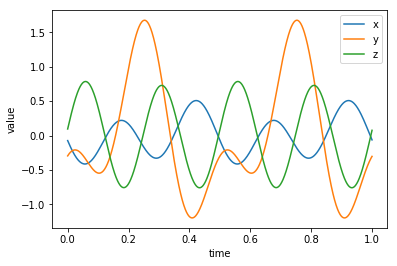

In [6]:
#We create three input nodes for x, y, z and assign them a white noise generated with nengo.processes
with net:
    x, y, z = [nengo.Node(nengo.processes.WhiteSignal(0.5, 5, seed=s))for s in range(3)]
    
#The matplot package can give us a graphical representation of the signals [OPTIONAL]  
plt.figure()
plt.plot(np.linspace(0 ,1, 1000), x.output.run(1.0), label='x')
plt.plot(np.linspace(0 ,1, 1000), y.output.run(1.0), label='y')
plt.plot(np.linspace(0 ,1, 1000), z.output.run(1.0), label='z')
plt.xlabel("time")
plt.ylabel("value")
plt.legend();


Now, we can start shaping the model. We will need three ensembles. The first one computes (2x+1)*y^2, while second second one computes cos(z). The third one takes the output of the second ensemble and square it to get (cos(z))^2. Of course, there are various structures we could have chosen to compute this function and we encourage you to expirement other ways.

In [7]:
with net:
    #First ensemble is composed of 50 neurons of type Rectified linear, taking 2 inputs (x and y) each
    ens1 = nengo.Ensemble(50, 2, neuron_type = nengo.RectifiedLinear())
    
    #The second and third ensemble are composed of 25 neurons, taking a single input (z).
    ens2 = nengo.Ensemble(25, 1, neuron_type = nengo.RectifiedLinear())
    ens3 = nengo.Ensemble(25, 1, neuron_type = nengo.RectifiedLinear())

Connecting the objects

In [8]:
with net:
    #Notice how ens1 is bi-dimensional, meaning each neuron can take 2 inputs
    nengo.Connection(x, ens1[0])
    nengo.Connection(y, ens1[1])
    
    nengo.Connection(z, ens2)
    
    #We create an output node. ens1 and ens3 will be its inputs, to compute the function
    f = nengo.Node(size_in=1)
    
    #The connection over ens1 and f computes the firt half of the funciton
    nengo.Connection(ens1, f, function=lambda x: (2*x[0] + 1) * x[1] ** 2)
    #The connection over ens2 and ens3 computes the cos wave
    nengo.Connection(ens2, ens3, function=np.cos)
    #The connection over ens3 and output f computes the squared cos wave
    nengo.Connection(ens3, f, function=np.square)
    

In [9]:
#We now create variables that will gather simulation results, using the probe function
with net:
    x_p = nengo.Probe(x)
    y_p = nengo.Probe(y)
    z_p = nengo.Probe(z)
    f_p = nengo.Probe(f)
    

All the components are now ready for a first simulation. We are going to define a target function  to compare our model's performance with.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:00                                                 


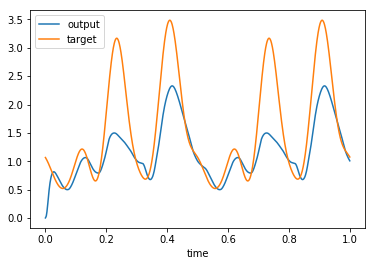

In [10]:
def target_func(x, y, z):
    return ((2*x + 1)*y ** 2) + np.cos(z) ** 2

#We now use nengo_dl to create a simulation object to which we assign the network we built
with nengo_dl.Simulator(net) as sim:
    #Let's run the simulation for 1 second
    sim.run(1.0)

    plt.figure()
    plt.plot(sim.trange(), sim.data[f_p], label="output")
    plt.plot(sim.trange(), target_func(sim.data[x_p], sim.data[y_p],
                                       sim.data[z_p]), label="target")
    plt.legend()
    plt.xlabel("time")

You can see that the model isn't doing very well for now. There's a considerable error between the output of the model and the target function. The model needs to be trained. The goal is to optimize the weights on each connection between objects, in order to minimize the error.

To do so we need to specify a training data set. Numpy package allows us to generate numbers randomly in a certain range. We will be using a 1000 inputs for x, y, z ranging from -1 to 1, each of our inputs are 1D, and we only need to train for one timestep at a time. We will then generate an expected output for each of the input sets.

In [11]:
#Let's define inputs x,y,z

trainSet = {x: np.random.uniform(-1, 1, size = (1000, 1, 1)),
            y: np.random.uniform(-1, 1, size = (1000, 1, 1)),
            z: np.random.uniform(-1, 1, size = (1000, 1, 1))}
    
#Let's define the output
trainSet[f_p] = target_func(trainSet[x], trainSet[y], trainSet[z])

Nengo_dl contains a function to check the error of the network on the data after running  simulation. We’ll use mean-squared-error (MSE) as our error measure. We'll also divide our training set into minibatches of 40 inputs each instead of going through a 1000 inputs one at a time.

In [16]:
sim.close()
with nengo_dl.Simulator(net, minibatch_size=40) as sim:
    print("pre-training mse:", sim.loss(trainSet, {f_p: "mse"}))

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Calculation finished in 0:00:00                                                
pre-training mse: 1.5130769
